In [ ]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

In [308]:
os.listdir('./')

['.ipynb_checkpoints',
 '.log',
 'job_companies.csv',
 'job_tags.csv',
 'sample_output_job.csv',
 'submission.csv',
 'tags.csv',
 'test_job.csv',
 'train.csv',
 'Untitled.ipynb',
 'user_tags.csv']

In [ ]:
# 훈련데이터
train_df = pd.read_csv('./train.csv')
print(train_df.shape)
train_df.head(3)

In [ ]:
# 테스트 데이터
test_df = pd.read_csv('./test_job.csv')
print(test_df.shape)
test_df.head(3)

In [ ]:
# Job 태그 : 하나의 Job에 여러 태그 가능
job_tag_df = pd.read_csv('./job_tags.csv')
print(job_tag_df.shape)
job_tag_df.head(3)

In [ ]:
# User tag : 각 개발자가 등록한 관심 태그
user_tag_df = pd.read_csv('./user_tags.csv')
print(user_tag_df.shape)
user_tag_df.head(3)

In [ ]:
# company
company_df = pd.read_csv('./job_companies.csv')
print(company_df.shape)
company_df.head(3)

In [ ]:
# real tag
tags = pd.read_csv('./tags.csv')
print(tags.shape)
tags.head(3)

### Feature Engineering

#### CompanySize

In [ ]:
# add companySize to train,test_df
train_df = train_df.merge(company_df[['jobID','companySize']], on='jobID')
test_df = test_df.merge(company_df[['jobID','companySize']], on='jobID')
train_df.head(3)

In [ ]:
def func(data):
    if data == '1000 이상': return 1000
    data = data.split('-')
    data = (int(data[0])+int(data[1]))//2
    return data
train_df['companySize'] = train_df['companySize'].apply(lambda x: func(x) if type(x)==str else x)
test_df['companySize'] = test_df['companySize'].apply(lambda x: func(x) if type(x)==str else x)

In [ ]:
print(train_df['companySize'].isna().sum())
print(test_df['companySize'].isna().sum())

In [ ]:
def Fillna_median(df):
    median = df['companySize'].median()
    return df['companySize'].fillna(median)
train_df['companySize'] = Fillna_median(train_df)
test_df['companySize'] = Fillna_median(test_df)

#### tag match count

In [ ]:
def Tag_match(df):
    from tqdm.notebook import tqdm
    tag_match = []
    User = df['userID']
    Job = df['jobID']
    for user, job in tqdm(zip(User, Job)):
        user_tag_list = user_tag_df[user_tag_df['userID']==user]['tagID'].values
        job_tag_list = job_tag_df[job_tag_df['jobID']==job]['tagID'].values
        job_tag_total = len(job_tag_list)
        cnt = 0
        for i in user_tag_list:
            if i in job_tag_list:
                cnt += 1
        tag_match.append(cnt/job_tag_total)
    return tag_match
train_df['tag_match_rate'] = Tag_match(train_df)
test_df['tag_match_rate'] = Tag_match(test_df)

#### mean encoding??????

In [ ]:
# mean encoding
train_tag_df = job_tag_df.merge(train_df[['jobID', 'applied']], on='jobID', how='left')
tag_mean = train_tag_df.groupby(by=['tagID'])[['applied']].mean()

def MeanEncoding(df):
    from tqdm.notebook import tqdm
    tag_encoding = []
    for i in tqdm(df['jobID']):
        tag = train_tag_df[train_tag_df['jobID']==i]['tagID'].values
        mean = 0
        for j in tag:
            mean += tag_mean[tag_mean.index==j]['applied'].values[0]
        tag_encoding.append(mean)
    return tag_encoding
train_df['jobID'] = MeanEncoding(train_df)
test_df['jobID'] = MeanEncoding(test_df)

In [ ]:
test_df['jobID'] = test_df['jobID'].fillna(test_df['jobID'].mean())

In [ ]:
tags.keyword.unique()[:10]
# -> 단어 유사도...?

### EDA

<AxesSubplot:xlabel='tag_match_rate', ylabel='Density'>

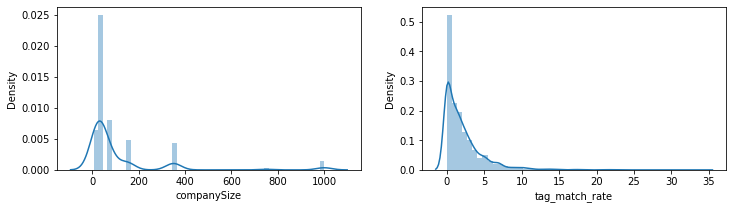

In [138]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(1, 2, figsize=(12,3))
sns.distplot(train_df['companySize'], ax=ax[0])
sns.distplot(train_df['tag_match_rate'], ax=ax[1])

<AxesSubplot:xlabel='tag_match_rate', ylabel='Density'>

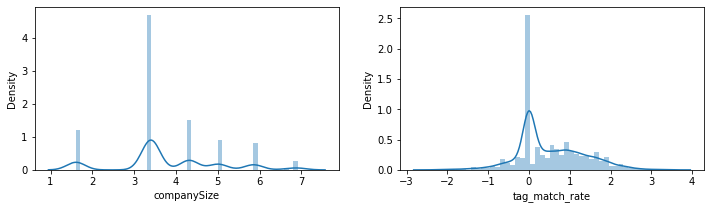

In [139]:
log_size = train_df['companySize'].apply(lambda x: np.log(x) if x!=0 else x)
log_rate = train_df['tag_match_rate'].apply(lambda x: np.log(x) if x!=0 else x)

f, ax = plt.subplots(1, 2, figsize=(12,3))
sns.distplot(log_size, ax=ax[0])
sns.distplot(log_rate, ax=ax[1])

In [ ]:
def Log(df):
    df['companySize'] = df['companySize'].apply(lambda x: np.log(x) if x!=0 else x)
    df['tag_match_rate'] = df['tag_match_rate'].apply(lambda x: np.log(x) if x!=0 else x)
Log(train_df); Log(test_df)

### Preprocessing

In [ ]:
concat_df = pd.concat([train_df, test_df])

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in ['userID']:
    concat_df[col] = le.fit_transform(concat_df[col])
    
train_df = concat_df.iloc[:train_df.shape[0], :]
test_df = concat_df.iloc[train_df.shape[0]:, :]
train_df['applied'] = train_df['applied'].astype(int)
test_df.drop('applied', axis=1, inplace=True)

In [ ]:
def Scalling(df, scaler='standard', label_col=None):
    'scaler = standard, minmax, maxabs, robust'
    from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
    if scaler == 'standard': scaler = StandardScaler()
    elif scaler == 'minmax': scaler = MinMaxScaler()
    elif scaler == 'maxabs': scaler = MaxAbsScaler()
    elif scaler == 'robust': scaler = RobustScaler()
    
    if label_col:
        df2 = df.drop(label_col, axis=1)
        val = scaler.fit_transform(df2)
        df2 = pd.DataFrame(val, columns=df2.columns, index=df.index)
        df2[label_col] = df[label_col]; df = df2.copy()
    else:
        val = scaler.fit_transform(df)
        df = pd.DataFrame(val, columns=df.columns, index=df.index)
    return df

In [ ]:
train_df[['companySize', 'tag_match_rate']] = Scalling(train_df[['companySize', 'tag_match_rate']], scaler='minmax')

### train and predict

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [147]:
fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=121)

X = train_df.drop('applied', axis=1)
y = train_df['applied']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=121)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(4800, 4) (1200, 4)
(4800,) (1200,)


In [148]:
rf = RandomForestClassifier(random_state=121, n_estimators=100, n_jobs=2)

rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print(f'accuracy is {accuracy_score(pred, y_test):.4f}')

cv_result = cross_val_score(rf, X, y, scoring='accuracy', n_jobs=2, cv=fold)
print(f'cv accuracy is {cv_result.mean():.4f}')

accuracy is 0.8417
cv accuracy is 0.8498


<AxesSubplot:>

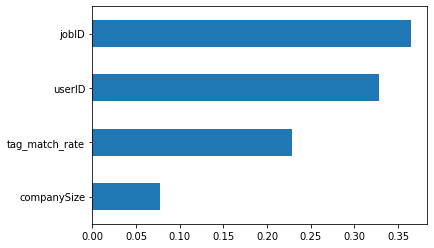

In [150]:
pd.Series(rf.feature_importances_, X.columns).sort_values().plot.barh()

In [235]:
# LightGBM
from lightgbm import LGBMClassifier

n_estimators = 1000
num_leaves = 12
max_depth = 7
min_child_samples = 10
learn_rate = 0.04

light = LGBMClassifier(n_estimators=n_estimators, num_leaves=num_leaves,
                       max_depth=max_depth, random_state=121,
                       min_child_samples=min_child_samples,
                       learning_rate=learn_rate)
light.fit(X_train, y_train, eval_set=[(X_test,y_test)], early_stopping_rounds=50, verbose=0)
print(light.best_iteration_)
n_estimators = light.best_iteration_

light = LGBMClassifier(n_estimators=n_estimators, num_leaves=num_leaves,
                       max_depth=max_depth, random_state=121,
                       min_child_samples=min_child_samples,
                       learning_rate=learn_rate)
light.fit(X_train, y_train)
pred = light.predict(X_test)

cv_result = cross_val_score(light, X, y, scoring='accuracy', cv=fold, n_jobs=2)
print('accuracy score is: {:.4f}'.format(cv_result.mean()))

259
accuracy score is: 0.8638


In [238]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
LR = LogisticRegression()
KN = KNeighborsClassifier(n_neighbors=4)
NB = GaussianNB()
EX = ExtraTreesClassifier()
Ada = AdaBoostClassifier(n_estimators=100)
RF = RandomForestClassifier()

models = [LR, KN, NB, EX, Ada, RF, light]
models_name = ['Logistic', 'KNeighbors', 'Naive', 'Extra', 'Ada', 'Random', 'light']
preds = []
for model, name in zip(models, models_name):
    cv_result = cross_val_score(model, X, y, scoring='accuracy', cv=fold).mean()
    
    model.fit(X_train, y_train)
    preds.append(model.predict(X_test))
    
    print(f'{name} : {cv_result:.4f}')

Logistic : 0.8583
KNeighbors : 0.8502
Naive : 0.8522
Extra : 0.8377
Ada : 0.8585
Random : 0.8495
light : 0.8638


<AxesSubplot:>

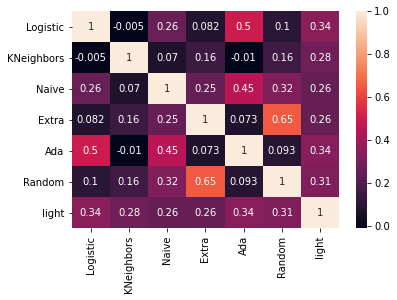

In [247]:
pred_df = pd.DataFrame(preds).T
pred_df.columns = models_name
sns.heatmap(pred_df.corr(), annot=True)

In [303]:
from sklearn.ensemble import VotingClassifier
import itertools
from tqdm.notebook import tqdm
Models = [LR, KN, NB, EX, Ada, RF, light]
best_score = 0
available_combine = range(2,len(Models))
for num in tqdm(available_combine):
    for i in itertools.combinations(Models,num):
        models = []
        for j in i:
            models.append(j)
        estimators = []
        for n, model in enumerate(models):
            estimators.append((str(n), model))
        voting = VotingClassifier(estimators=estimators, voting='hard')
        cv_result = cross_val_score(voting, X, y, scoring='accuracy', cv=fold).mean()
        if cv_result > best_score:
            best_score = cv_result
            best_combinations = i
            best_model = voting
    print(f'{best_score:.4f}')
print(f'{i} {best_score:.4f}')

  0%|          | 0/5 [00:00<?, ?it/s]

0.8607
0.8620
0.8620
0.8620
0.8620
(KNeighborsClassifier(n_neighbors=4), GaussianNB(), ExtraTreesClassifier(), AdaBoostClassifier(n_estimators=100), RandomForestClassifier(), LGBMClassifier(learning_rate=0.04, max_depth=7, min_child_samples=10,
               n_estimators=259, num_leaves=12, random_state=121)) 0.8620


### Submission

In [ ]:
model = light
model.fit(X, y)
predict = model.predict(test_df)

submission = pd.DataFrame(predict, columns=['applied'])
submission

In [ ]:
submission.to_csv('./submission.csv', index=False)